In [1]:
import os
os.environ['NETKET_EXPERIMENTAL_SHARDING'] = '1'
os.environ['NETKET_EXPERIMENTAL_FFT_AUTOCORRELATION'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"

In [2]:
import netket as nk

import sys
# sys.path.append('/scratch/samiz/Vscore_ThermodynamicLimit_Analysis/AFM_VMC')
# sys.path.append('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/AFM_VMC')
sys.path.append('/scratch/samiz/Model')

import jax.numpy as jnp
import matplotlib.pyplot as plt

import flax.linen as nn
from typing import Any
from netket.jax import logsumexp_cplx

from Afm_Model_functions import *
from vmc_2spins_sampler import *
from Spin_Observables import *
import pickle
import ViT_2d_Vers6 as vit
from data_extracter import *
import os
from jax import vmap



In [4]:
L = 8

# hi2d = nk.hilbert.Spin(s=0.5, N=L**2, constraint=Mtot_Parity_Constraint(parity=0))
TriGraph = nk.graph.Triangular(extent = [L,L], pbc = True)

pHa = {
    'L': L,
    'J1' : 1.0,
    'J2' : 0.4375,
    'Dxy': 0.75,
    'd' : 0.1,
    'dprime' : 0.5,
    'sublattice': [0,1,2,3,4,5,6,7,
                   16,17,18,19,20,21,22,23,
                   32,33,34,35,36,37,38,39,
                   48,49,50,51,52,53,54,55]
}

Ha64, hi2d = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=True,
                        parity=0., sublattice = None, make_rotation=False, exchange_XY=False)

Ha64_SS_J2 = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=False,
                        parity=0., sublattice = pHa['sublattice'], make_rotation=True, exchange_XY=True)
#--------------------------------------------------------------------------------------------------------------------------
pHa['sublattice'] = [0,2,4,6,9,11,13,15,16,18,20,22,25,27,29,31,
                   32,34,36,38,41,43,45,47,48,50,52,54,57,59,61,63]

Ha64_SS_J2_Diff = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=False,
                        parity=0., sublattice = pHa['sublattice'], make_rotation=True, exchange_XY=True)

#--------------------------------------------------------------------------------------------------------------------------
pHa['sublattice'] = sublattice(L)
Ha64_SS_J3 = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=False,
                        parity=0., sublattice = pHa['sublattice'], make_rotation=True, exchange_XY=True)

#--------------------------------------------------------------------------------------------------------------------------
print('the Hilbert space is: ', hi2d)
XX = Exchange_OP(hi2d, TriGraph).to_jax_operator()

sa_Ha = nk.sampler.MetropolisHamiltonian(hilbert=hi2d, hamiltonian=XX, n_chains=32, sweep_size = 3* hi2d.size)
sa_ex = nk.sampler.MetropolisExchange(hilbert=hi2d, graph=TriGraph, n_chains=32, sweep_size=3*hi2d.size)

rules5050 = nk.sampler.rules.MultipleRules(rules = [sa_Ha.rule, sa_ex.rule], probabilities = [0.5, 0.5])
sa_HaEx5050 = nk.sampler.MetropolisSampler(hi2d, rules5050, n_chains=64, sweep_size=3*hi2d.size)




the Hilbert space is:  Spin(s=1/2, N=64, ordering=inverted, <vmc_2spins_sampler.Mtot_Parity_Constraint object at 0x7f0f283a1b10>)


In [5]:

def Sz_tot(graph, hilbert):
    """
    input:
    graph: (netket.graph) the graph of the system
    hilbert: (netket.hilbert) the hilbert space of the system

    return:
    the total Sz operator
    """
    Sz = 0.0
    Ntot = graph.n_nodes
    for i in range(Ntot):
        Sz += sigmaz(hilbert, i)
    return Sz/Ntot

Mtot = Sz_tot(nk.graph.Triangular(extent=[L,L], pbc=True), hi2d).to_jax_operator() 

In [6]:
pVit = {
    'd': 24,
    'h': 6,
    'nl': 1,
    'Dtype': jnp.float64,
    'hidden_density': 1,
    'L': L,
    'Cx': 4,
    'Cy': 4,
    'patch_arr': HashableArray(jnp.array([[0,1,2,3,8,9,10,11,16,17,18,19,24,25,26,27],
                                          [4,5,6,7,12,13,14,15,20,21,22,23,28,29,30,31],
                                          [32,33,34,35,40,41,42,43,48,49,50,51,56,57,58,59],
                                          [36,37,38,39,44,45,46,47,52,53,54,55,60,61,62,63]])),
    }

pVit['transls'] = HashableArray(vit.get_translation(L, L, L**2, 4, 4))



m_Vit44 = vit.Vit_2d_full_symm(patch_arr=(pVit['patch_arr']), embed_dim=pVit['d'], num_heads=pVit['h'], nl=pVit['nl'],
                                Dtype=pVit['Dtype'], L=pVit['L'], Cx=pVit['Cx'], Cy=pVit['Cy'], hidden_density=pVit['hidden_density'],
                                recover_full_transl_symm=True, translations=pVit['transls'], recover_spin_flip_symm=True)

pVit['Cx'] = 2; pVit['Cy'] = 2
pVit['patch_arr'] = HashableArray(jnp.array([[0,1,8,9], [2,3,10,11], [4,5,12,13], [6,7,14,15],
                                           [16,17,24,25], [18,19,26,27], [20,21,28,29], [22,23,30,31], 
                                             [32,33,40,41], [34,35,42,43], [36,37,44,45], [38,39,46,47],
                                             [48,49,56,57], [50,51,58,59], [52,53,60,61], [54,55,62,63]]))

pVit['transls'] = HashableArray(vit.get_translation(L, L, L**2, 2, 2)) 

m_Vit22 = vit.Vit_2d_full_symm(patch_arr=(pVit['patch_arr']), embed_dim=pVit['d'], num_heads=pVit['h'], nl=pVit['nl'],
                                Dtype=pVit['Dtype'], L=pVit['L'], Cx=pVit['Cx'], Cy=pVit['Cy'], hidden_density=pVit['hidden_density'],
                                recover_full_transl_symm=True, translations=pVit['transls'], recover_spin_flip_symm=True)


now introduce projection to full symmetry:

In [7]:
ID = jnp.arange(0, L**2)
R = vit.make_first_reflection(ID, L)
Glide_Rot = vit.rot180_trans1(ID, L)
GRR = vit.trans_product(Glide_Rot, R)
arr = jnp.array([ID, R, Glide_Rot, GRR])
# arr = jnp.array([ID,R])
m_vit22_ref = vit.reflection_wrapper(model=m_Vit22, reflections=HashableArray(arr))
m_vit44_ref = vit.reflection_wrapper(model=m_Vit44, reflections=HashableArray(arr))

In [ ]:
# nk.vqs.MCState(sampler=sa_HaEx5050, model=m2_vit, n_samples=2**12, n_discard_per_chain=16, chunk_size=2**8)

In [42]:
# # Load pickled parameters
# with open('patching_xy22/Log_Files/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as f:
#     ps = pickle.load(f)

# # Correctly update VMC state
# new_variables = vs_vit_ref.variables.copy()
# new_variables['params']['model'] = ps['params']
# vs_vit_ref.variables = new_variables

In [62]:
# print(vs_vit_ref.parameters['model']['ViT_2d_0']['Final_Complex_Layer_0']['LayerNorm_0']['scale'],
#        vs_vit_ref.variables['params']['model']['ViT_2d_0']['Final_Complex_Layer_0']['LayerNorm_0']['scale'],
#       ps['params']['ViT_2d_0']['Final_Complex_Layer_0']['LayerNorm_0']['scale'])

[2.61900829 1.70527663 1.25869917 1.66077574 1.31554923 2.01869711
 1.34873569 1.44573831 3.30520922 1.42506482 1.02975513 1.12412088
 2.05556626 1.86192988 1.45300459 1.80771375 1.4822176  2.32121121
 3.09032266 1.35980592 2.84503791 2.10689202 2.0143646  2.24502448] [2.61900829 1.70527663 1.25869917 1.66077574 1.31554923 2.01869711
 1.34873569 1.44573831 3.30520922 1.42506482 1.02975513 1.12412088
 2.05556626 1.86192988 1.45300459 1.80771375 1.4822176  2.32121121
 3.09032266 1.35980592 2.84503791 2.10689202 2.0143646  2.24502448] [2.61900829 1.70527663 1.25869917 1.66077574 1.31554923 2.01869711
 1.34873569 1.44573831 3.30520922 1.42506482 1.02975513 1.12412088
 2.05556626 1.86192988 1.45300459 1.80771375 1.4822176  2.32121121
 3.09032266 1.35980592 2.84503791 2.10689202 2.0143646  2.24502448]


In [14]:
# print(vs_vit_ref.parameters['model'].keys(), ps['params'].keys())

dict_keys(['ViT_2d_0']) dict_keys(['ViT_2d_0'])


In [9]:
# import the good parameters:
vit_44 = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit44, n_samples=2**12, n_discard_per_chain=16)
vit_44_ref = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_vit44_ref, n_samples=2**12, n_discard_per_chain=16, chunk_size=2**8)

with open('patching_xy44/Log_Files/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as f:
    ps = pickle.load(f)
    vit_44.variables = ps
    vit_44_ref.variables = {'params': {'model':ps['params']}}

#--------------------------------------------------------------------------------------------------------------------------


vit_44_signJ2 = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit44, n_samples=2**12, n_discard_per_chain=16)
vit_44_signJ2_ref = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_vit44_ref, n_samples=2**12, n_discard_per_chain=16, chunk_size=2**6)
with open('patching_xy44_signstructure/Log_Files/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as f:
    ps = pickle.load(f)
    vit_44_signJ2.variables = ps
    vit_44_signJ2_ref.variables = {'params': {'model':ps['params']}}

#--------------------------------------------------------------------------------------------------------------------------
vit_44_signJ3 = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit44, n_samples=2**12, n_discard_per_chain=16)
vit_44_signJ3_ref = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_vit44_ref, n_samples=2**12, n_discard_per_chain=16, chunk_size=2**6)
with open('patching_xy44_signstructure/Log_Files_J3/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as f:
    ps = pickle.load(f)
    vit_44_signJ3.variables = ps
    vit_44_signJ3_ref.variables = {'params': {'model':ps['params']}}

#--------------------------------------------------------------------------------------------------------------------------

vit_44_signJ2_Diff = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit44, n_samples=2**12, n_discard_per_chain=16)
vit_44_signJ2_Diff_ref = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_vit44_ref, n_samples=2**12, n_discard_per_chain=16, chunk_size=2**6)
with open('patching_xy44_signstructure/Log_Files_J2_Diff/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as f:
    ps = pickle.load(f)
    vit_44_signJ2_Diff.variables = ps
    vit_44_signJ2_Diff_ref.variables = {'params': {'model':ps['params']}}

#--------------------------------------------------------------------------------------------------------------------------

vit_22 = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit22, n_samples=2**12, n_discard_per_chain=16)
vit_22_ref = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_vit22_ref, n_samples=2**12, n_discard_per_chain=16, chunk_size=2**6)
with open('patching_xy22/Log_Files/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as f:
    ps = pickle.load(f)
    vit_22.variables = ps
    vit_22_ref.variables = {'params': {'model':ps['params']}}


In [10]:
print(vit_22.n_parameters)
print(vit_44.n_parameters)
print(vit_44_signJ2_Diff.n_parameters)
print(vit_44_signJ3_ref.n_parameters)
print(vit_44_signJ2.n_parameters)
print(vit_44_signJ2_ref.n_parameters)



4578
4794
4794
4794
4794
4794


## Compute energy with exra projection to reflection:

In [9]:
vit_44_ref.n_discard_per_chain=512

In [10]:
vit_44_ref.reset()

vit_44_ref.expect(Ha64.to_jax_operator())


-95.760-0.000j ± 0.024 [σ²=1.887, R̂=1.0094, τ=1.0<3.2]

In [34]:
print(64 * 1.417 / (-95.744)**2 )

0.009892969934084474


In [17]:
vit_44_signJ2_ref.n_discard_per_chain=512

In [33]:
vit_44_signJ2_ref.reset()

vit_44_signJ2_ref.expect(Ha64_SS_J2.to_jax_operator())

-95.068-0.000j ± 0.037 [σ²=8.563, R̂=1.0054, τ=0.8<1.8]

In [31]:
vit_22_ref.n_discard_per_chain=512

In [32]:
vit_22_ref.reset()
vit_22_ref.expect(Ha64.to_jax_operator())

-94.787+0.012j ± 0.046 [σ²=4.417, R̂=1.0198, τ=1.8<4.9]

In [77]:
vit_44_signJ2_Diff.reset()
vit_44_signJ2_Diff_ref.reset()
print(vit_44_signJ2_Diff.expect(Ha64_SS_J2_Diff.to_jax_operator()))
print(vit_44_signJ2_Diff_ref.expect(Ha64_SS_J2_Diff.to_jax_operator()))

-91.7+0.0j ± 1.4 [σ²=148.0, R̂=1.3843, τ=1.0<7.6]
-89.1+0.0j ± 1.7 [σ²=216.1, R̂=1.3766, τ=1.0<7.6]


In [69]:
vit_44_signJ3.reset()
vit_44_signJ3_ref.reset()
print(vit_44_signJ3.expect(Ha64_SS_J3.to_jax_operator()))
print(vit_44_signJ3_ref.expect(Ha64_SS_J3.to_jax_operator()))


-78.5-0.0j ± 4.3 [σ²=758.2, R̂=1.3542, τ=3.4<15.8]
-88.3+0.0j ± 2.2 [σ²=378.2, R̂=1.2921, τ=5.1<16.3]


In [58]:
print(vit_22.expect(Ha64.to_jax_operator()), vit_22_ref.expect(Ha64.to_jax_operator()))

-94.478+0.004j ± 0.035 [σ²=3.248, R̂=1.0051, τ=1.1<2.2] -94.755-0.005j ± 0.040 [σ²=3.715, R̂=1.0141, τ=2.3<6.1]


In [11]:
class rbm_trans_flip(nn.Module):
    translations: jnp.ndarray
    alpha : float
    param_dtype: Any = jnp.dtype

    @nn.compact
    def __call__(self, x):
        rbm = nk.models.RBM(alpha=self.alpha, param_dtype=self.param_dtype)

        x = jnp.apply_along_axis(lambda elt: jnp.array([rbm(x[...,elt]), rbm(-x[...,elt])]), axis = -1, arr =jnp.asarray(self.translations))
        x = x.reshape(-1,x.shape[-1])
        return logsumexp_cplx(x, axis = 0)

In [12]:
transls = vit.get_translation(L, L, L**2, 4, 4)
full_sym = nk.graph.Graph(edges=make_colored_edges(L,L)).automorphisms().to_array()

rbm1 = rbm_trans_flip(translations=HashableArray(transls), alpha=1.0, param_dtype=complex)
rbm1_full = rbm_trans_flip(translations=HashableArray(full_sym), alpha=1.0, param_dtype=complex)

vs_rbm1_SS = nk.vqs.MCState(sampler=sa_HaEx5050, model=rbm1, n_samples=2**12, n_discard_per_chain=16, chunk_size=2**8)
vs_rbm1_full_SS = nk.vqs.MCState(sampler=sa_HaEx5050, model=rbm1_full, n_samples=2**12, n_discard_per_chain=16, chunk_size=2**8)
with open('8x8_XYZ_RBM/Log_Files/log_saHaEx5050_rbm_alpha1.0_transflip_SS.pickle', 'rb') as f:
    ps = pickle.load(f)
    vs_rbm1_SS.variables = ps
    vs_rbm1_full_SS.variables = ps


In [13]:
vs_rbm1_SS.reset()
vs_rbm1_full_SS.reset()

print(vs_rbm1_SS.expect(Ha64_SS_J2.to_jax_operator()))
print(vs_rbm1_full_SS.expect(Ha64_SS_J2.to_jax_operator()))

-93.890+0.012j ± 0.046 [σ²=9.452, R̂=1.0069, τ=0.8<1.7]
-93.926-0.003j ± 0.054 [σ²=8.657, R̂=1.0104, τ=0.9<2.7]


In [64]:
print(vs_rbm1_full_SS.n_parameters)
print(vs_rbm1_SS.n_parameters)

4224
4224


In [17]:
data = {}
path_vit22 = 'patching_xy22/Log_Files'
path_vit44 = 'patching_xy44/Log_Files'
path_vit44_sign = 'patching_xy44_signstructure/Log_Files'
path_rbm = '8x8_XYZ_RBM/Log_Files'
paths = [path_vit22, path_vit44, path_vit44_sign, path_rbm]
names = ['vit22', 'vit44', 'vit44_sign', ' ']
for j, path in enumerate(paths):
    logs = [f for f in os.listdir(path) if '.log' in f]
    if path==path_rbm:
        extract_data(logs, data, path, ['log_saHaEx5050_'], [names[j]], L=8)
    else:
        extract_data(logs, data, path, ['log_vit_sampler_HaEx_5050'], [names[j]], L=8)
    


In [11]:
data.keys()

dict_keys(['vit22', 'vit22_transflip', 'vit44', 'vit44_transflip', 'vit44_trans', 'vit44_sign', 'vit44_sign_transflip', 'vit44_sign_trans_old', ' rbm_alpha1.0', ' rbm_alpha1.0_SS', ' rbm_alpha1.0_transflip_SS'])

/tmp/ipykernel_1096562/2758164114.py:28: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1)


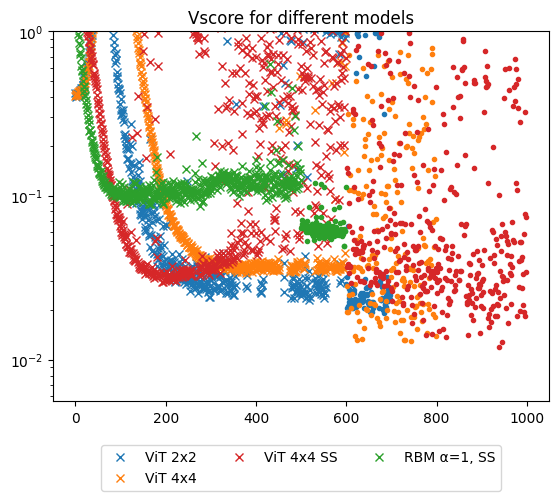

In [18]:
plt.figure()
plt.title('Vscore for different models')

step1 = len(data['vit22']['Vscore'])
plt.semilogy(data['vit22']['Vscore'], marker='x', linestyle='', label='ViT 2x2', color='tab:blue')
step2 = len(data['vit22_transflip']['Vscore'])
plt.semilogy(step1 + jnp.arange(0, step2), data['vit22_transflip']['Vscore'], marker='.', linestyle='', color='tab:blue')

step1 = len(data['vit44']['Vscore'])
plt.semilogy(data['vit44']['Vscore'], marker='x', linestyle='', label='ViT 4x4', color='tab:orange')
step2 = len(data['vit44_transflip']['Vscore'])
plt.semilogy(step1 + jnp.arange(0, step2), data['vit44_transflip']['Vscore'], marker='.', linestyle='', color='tab:orange')

step1 = len(data['vit44_sign']['Vscore'])
plt.semilogy(data['vit44_sign']['Vscore'], marker='x', linestyle='', label='ViT 4x4 SS', color='tab:red')
step2 = len(data['vit44_sign_transflip']['Vscore'])
plt.semilogy(step1 + jnp.arange(0, step2), data['vit44_sign_transflip']['Vscore'], marker='.', linestyle='', color='tab:red')

step1 = len(data[' rbm_alpha1.0_SS']['Vscore'])
plt.semilogy(data[' rbm_alpha1.0_SS']['Vscore'], marker='x', linestyle='', label='RBM α=1, SS', color='tab:green')
step2 = len(data[' rbm_alpha1.0_transflip_SS']['Vscore'])
plt.semilogy(step1 + jnp.arange(0, step2), data[' rbm_alpha1.0_transflip_SS']['Vscore'], marker='.', linestyle='', color='tab:green')



plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.ylim(0,1)
plt.show()



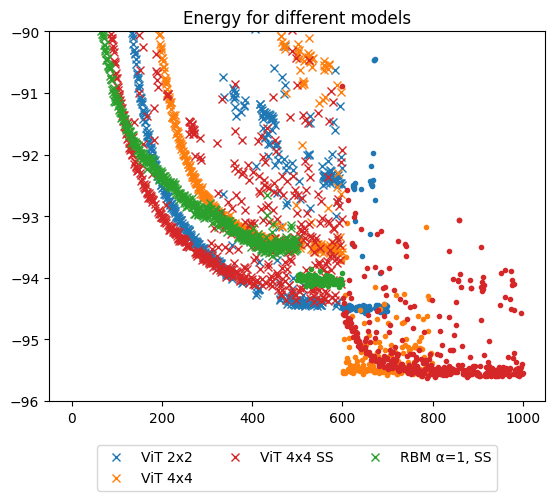

In [19]:
plt.figure()
plt.title('Energy for different models')

step1 = len(data['vit22']['Energy'])
plt.plot(data['vit22']['Energy'], marker='x', linestyle='', label='ViT 2x2', color='tab:blue')
step2 = len(data['vit22_transflip']['Energy'])
plt.plot(step1 + jnp.arange(0, step2), data['vit22_transflip']['Energy'], marker='.', linestyle='', color='tab:blue')

step1 = len(data['vit44']['Energy'])
plt.plot(data['vit44']['Energy'], marker='x', linestyle='', label='ViT 4x4', color='tab:orange')
step2 = len(data['vit44_transflip']['Energy'])
plt.plot(step1 + jnp.arange(0, step2), data['vit44_transflip']['Energy'], marker='.', linestyle='', color='tab:orange')

step1 = len(data['vit44_sign']['Energy'])
plt.plot(data['vit44_sign']['Energy'], marker='x', linestyle='', label='ViT 4x4 SS', color='tab:red')
step2 = len(data['vit44_sign_transflip']['Energy'])
plt.plot(step1 + jnp.arange(0, step2), data['vit44_sign_transflip']['Energy'], marker='.', linestyle='', color='tab:red')

step1 = len(data[' rbm_alpha1.0_SS']['Energy'])
plt.plot(data[' rbm_alpha1.0_SS']['Energy'], marker='x', linestyle='', label='RBM α=1, SS', color='tab:green')
step2 = len(data[' rbm_alpha1.0_transflip_SS']['Energy'])
plt.plot(step1 + jnp.arange(0, step2), data[' rbm_alpha1.0_transflip_SS']['Energy'], marker='.', linestyle='', color='tab:green')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.ylim(-96, -90)
plt.show()


In [14]:
print(data['vit22_transflip']['Energy'][-1], data['vit22_transflip']['Variance'][-1], data['vit22_transflip']['Vscore'][-1])
print(data[' rbm_alpha1.0_transflip_SS']['Energy'][-1], data[' rbm_alpha1.0_transflip_SS']['Variance'][-1], data[' rbm_alpha1.0_transflip_SS']['Vscore'][-1])

print(data['vit44_sign_transflip']['Energy'][-1], data['vit44_sign_transflip']['Variance'][-1], data['vit44_sign_transflip']['Vscore'][-1])

print(data['vit44_transflip']['Energy'][-1], data['vit44_transflip']['Variance'][-1],  data['vit44_transflip']['Vscore'][-1])


-94.53223697683256 3.772206558285407 0.027015087686946385
-93.91358550269321 15.489532761627725 0.11239634777270137
-95.54301692702678 4.872271992316777 0.034158949488900525
-95.54202890661995 1.979159153047636 0.01387594861177827


In [15]:
64 * 1.97 / (-95.543016927)**2

0.013811736958111734

#### Magnetization

In [20]:
print(vs_rbm1_SS.expect(Mtot))
print(vs_rbm1_full_SS.expect(Mtot), '\n')
print(vit_22.expect(Mtot))
print(vit_22_ref.expect(Mtot), '\n')
print(vit_44.expect(Mtot))
print(vit_44_ref.expect(Mtot), '\n')
print(vit_44_signJ2.expect(Mtot))
print(vit_44_signJ2_ref.expect(Mtot), '\n')
print(vit_44_signJ3.expect(Mtot))
print(vit_44_signJ3_ref.expect(Mtot), '\n')
print(vit_44_signJ2_Diff.expect(Mtot))
print(vit_44_signJ2_Diff_ref.expect(Mtot))


0.00050+0.00000j ± 0.00059 [σ²=0.00124, R̂=1.0098, τ=0.8<2.0]
-0.0044+0.0000j ± 0.0046 [σ²=0.0036, R̂=1.2415, τ=1.0<7.6] 

-0.00124+0.00000j ± 0.00094 [σ²=0.00196, R̂=1.0184, τ=1.0<3.3]
-0.00031-0.00000j ± 0.00068 [σ²=0.00159, R̂=1.0102, τ=1.0<3.1] 

-0.00084+0.00000j ± 0.00057 [σ²=0.00102, R̂=1.0130, τ=1.0<4.7]
-0.00043-0.00000j ± 0.00046 [σ²=0.00089, R̂=1.0086, τ=1.2<3.4] 

0.000+0.000j ± 0.011 [σ²=0.017, R̂=1.2598, τ=1.9<7.9]
-0.024+0.000j ± 0.012 [σ²=0.019, R̂=1.2541, τ=2.3<7.5] 

-0.0105+0.0000j ± 0.0042 [σ²=0.0031, R̂=1.1888, τ=1.6<7.4]
0.0001+0.0000j ± 0.0022 [σ²=0.0020, R̂=1.0981, τ=1.6<7.4] 

0.0083+0.0000j ± 0.0090 [σ²=0.0067, R̂=1.3353, τ=0.9<7.5]
0.013+0.000j ± 0.013 [σ²=0.012, R̂=1.3642, τ=0.9<4.1]


In [36]:
SpinSpin_Corrs = {}
SpinSpin_Corrs_Err = {}

def compute_spin_spin_corr(vs, label, make_rotate=False, sublattice=None):
    values = []
    errors = []
    for j in range(1, hi2d.size):
        op = SpinSpin(0, j, hi2d, make_rotation=make_rotate, sublattice=sublattice).to_jax_operator() 
        stats = vs.expect(op)
        values.append(stats.mean)
        errors.append(stats.error_of_mean)
    SpinSpin_Corrs[label] = values
    SpinSpin_Corrs_Err[label] = errors

compute_spin_spin_corr(vit_22, 'vit22', make_rotate=False)
compute_spin_spin_corr(vit_22_ref, 'vit22_ref', make_rotate=False)
compute_spin_spin_corr(vit_44, 'vit44', make_rotate=False)
compute_spin_spin_corr(vit_44_ref, 'vit44_ref', make_rotate=False)

pHa['sublattice'] = [0,1,2,3,4,5,6,7,
                   16,17,18,19,20,21,22,23,
                   32,33,34,35,36,37,38,39,
                   48,49,50,51,52,53,54,55]
compute_spin_spin_corr(vit_44_signJ2, 'vit44_signJ2', make_rotate=True, sublattice=pHa['sublattice'])
compute_spin_spin_corr(vit_44_signJ2_ref, 'vit44_signJ2_ref', make_rotate=True, sublattice=pHa['sublattice'])
compute_spin_spin_corr(vs_rbm1_SS, ' rbm_alpha1.0_SS', make_rotate=True, sublattice=pHa['sublattice'])
compute_spin_spin_corr(vs_rbm1_full_SS, ' rbm_alpha1.0_full_SS', make_rotate=True, sublattice=pHa['sublattice'])

pHa['sublattice'] = sublattice(L)
compute_spin_spin_corr(vit_44_signJ3, 'vit44_signJ3', make_rotate=True, sublattice=pHa['sublattice'])
compute_spin_spin_corr(vit_44_signJ3_ref, 'vit44_signJ3_ref', make_rotate=True, sublattice=pHa['sublattice'])
pHa['sublattice'] = [0,2,4,6,9,11,13,15,16,18,20,22,25,27,29,31,
                   32,34,36,38,41,43,45,47,48,50,52,54,57,59,61,63]
compute_spin_spin_corr(vit_44_signJ2_Diff, 'vit44_signJ2_Diff', make_rotate=True, sublattice=pHa['sublattice'])
compute_spin_spin_corr(vit_44_signJ2_Diff_ref, 'vit44_signJ2_Diff_ref', make_rotate=True, sublattice=pHa['sublattice'])




In [37]:
sublatt_J2 = [0,1,2,3,4,5,6,7,
                   16,17,18,19,20,21,22,23,
                   32,33,34,35,36,37,38,39,
                   48,49,50,51,52,53,54,55]

print(vit_44_ref.expect(SpinSpin(0, 32, hi2d, make_rotation=False, sublattice=sublatt_J2).to_jax_operator() ))
print(vit_22_ref.expect(SpinSpin(0, 32, hi2d, make_rotation=False, sublattice=sublatt_J2).to_jax_operator() ))
# vit_44_signJ3
print(vit_44_signJ2.expect(SpinSpin(0, 32, hi2d, make_rotation=True, sublattice=sublatt_J2).to_jax_operator() ))



0.680+0.000j ± 0.020 [σ²=1.305, R̂=1.0095, τ=0.8<1.9]
0.671-0.000j ± 0.017 [σ²=1.208, R̂=1.0069, τ=0.9<2.4]
0.786+0.000j ± 0.023 [σ²=0.973, R̂=1.0181, τ=0.9<3.8]


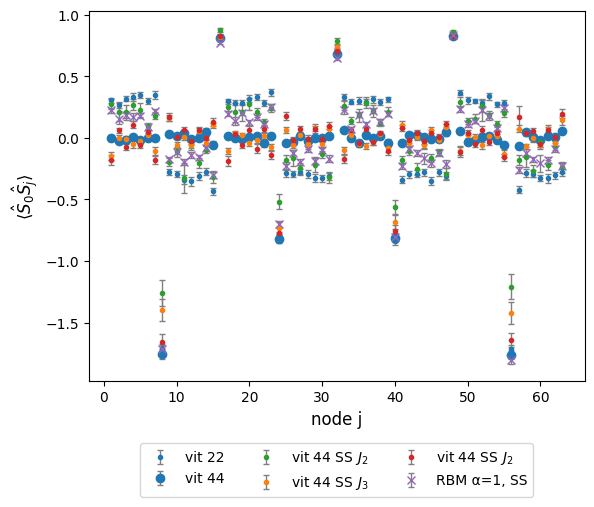

In [38]:
plt.figure()
plt.ylabel(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$', fontsize=12)
plt.xlabel('node j', fontsize=12)

plt.errorbar(jnp.arange(1, hi2d.size), np.real(SpinSpin_Corrs['vit22']), yerr=SpinSpin_Corrs_Err['vit22'], marker='.', label='vit 22', color='tab:blue', linestyle='', ecolor='gray', elinewidth=1, capsize=2)
plt.errorbar(jnp.arange(1, hi2d.size), np.real(SpinSpin_Corrs['vit44_ref']), yerr=SpinSpin_Corrs_Err['vit44_ref'], marker='o', linestyle='', label='vit 44', color='tab:blue', ecolor='gray', elinewidth=1, capsize=2)
plt.errorbar(jnp.arange(1, hi2d.size), np.real(SpinSpin_Corrs['vit44_signJ2']), yerr=SpinSpin_Corrs_Err['vit44_signJ2'], marker='.', linestyle='', label='vit 44 SS $J_2$ ', color='tab:green', ecolor='gray', elinewidth=1, capsize=2)
plt.errorbar(jnp.arange(1, hi2d.size), np.real(SpinSpin_Corrs['vit44_signJ3']), yerr=SpinSpin_Corrs_Err['vit44_signJ3'], marker='.', linestyle='', label = 'vit 44 SS $J_3$', color='tab:orange', ecolor='gray', elinewidth=1, capsize=2)
# plt.errorbar(jnp.arange(1, hi2d.size), SpinSpin_Corrs['vit44_signJ2_ref'], yerr=SpinSpin_Corrs_Err['vit44_signJ2_ref'], marker='x', linestyle='', label='ViT 4x4 $J_2$ sign, ref', color='tab:red')
plt.errorbar(jnp.arange(1, hi2d.size), np.real(SpinSpin_Corrs['vit44_signJ2_Diff']), yerr=SpinSpin_Corrs_Err['vit44_signJ2_Diff'], marker='.', linestyle='', label='vit 44 SS $J_2$', color='tab:red', ecolor='gray', elinewidth=1, capsize=2)
plt.errorbar(jnp.arange(1, hi2d.size), np.real(SpinSpin_Corrs[' rbm_alpha1.0_SS']), yerr=SpinSpin_Corrs_Err[' rbm_alpha1.0_SS'], marker='x', linestyle='', label='RBM α=1, SS', color='tab:purple', ecolor='gray', elinewidth=1, capsize=2)


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)



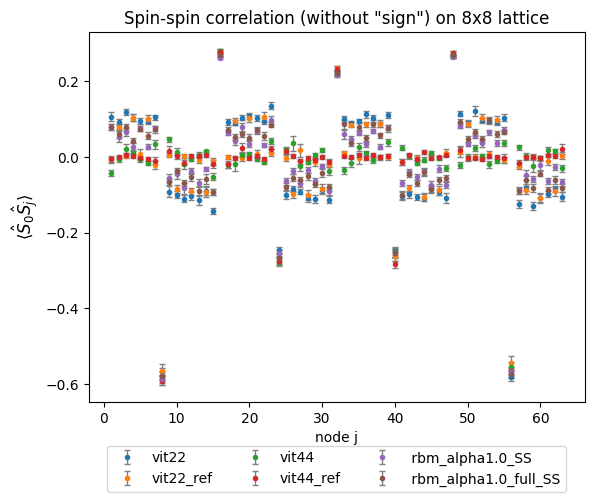

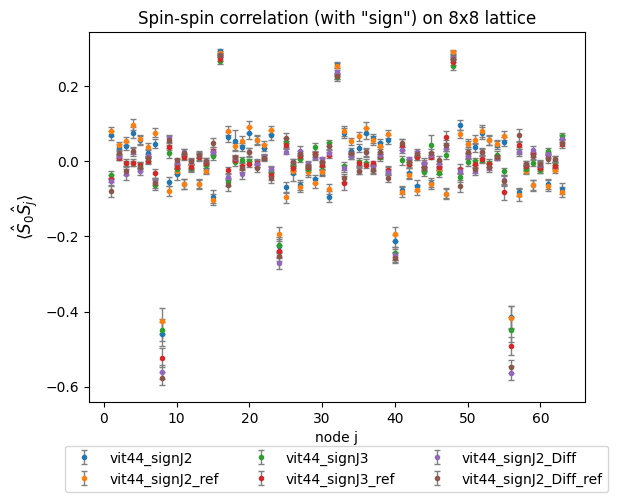

In [13]:
# Plot for keys that do not contain "sign"
plt.figure()
plt.title('Spin-spin correlation (without "sign") on 8x8 lattice')
plt.ylabel(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$', fontsize=12)
plt.xlabel('node j')
for key in SpinSpin_Corrs.keys():
    if "sign" not in key:
        plt.errorbar(x=np.arange(1, 64), y=np.real(SpinSpin_Corrs[key]), yerr=SpinSpin_Corrs_Err[key], fmt='.', linestyle='', label=key, ecolor='gray', elinewidth=1, capsize=2)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()

# Plot for keys that contain "sign"
plt.figure()
plt.title('Spin-spin correlation (with "sign") on 8x8 lattice')
plt.ylabel(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$', fontsize=12)
plt.xlabel('node j')
for key in SpinSpin_Corrs.keys():
    if "sign" in key:
        plt.errorbar(x=np.arange(1, 64), y=np.real(SpinSpin_Corrs[key]), yerr=SpinSpin_Corrs_Err[key], fmt='.', linestyle='', label=key, ecolor='gray', elinewidth=1, capsize=2)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()

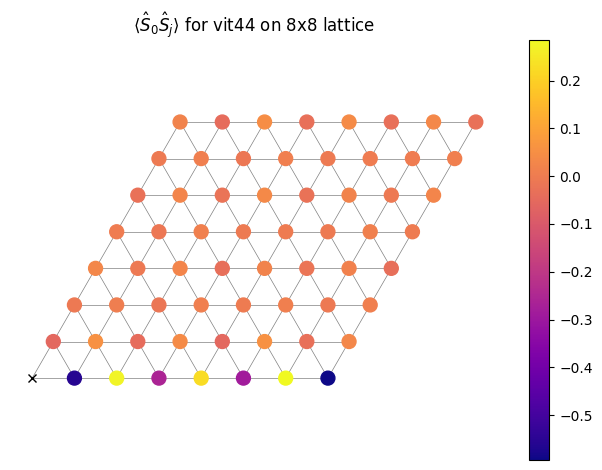

In [87]:
tri_open = nk.graph.Triangular(extent=[L, L], pbc=False)

xcoords = TriGraph.positions[:, 0]
ycoords = TriGraph.positions[:, 1]

plt.figure()
plt.title(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$ for vit44 on 8x8 lattice')
plt.xlabel('x-direction')
plt.ylabel('y-direction')
plt.axis('equal')
plt.axis('off')  # Remove the coordinate frame
for edge in tri_open.edges():
    start, end = tri_open._positions[edge[0]], tri_open._positions[edge[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=0.5, alpha=0.5, zorder=1)

plt.plot(xcoords[0], ycoords[0], marker='x', color='black')
plt.scatter(x=xcoords[1:], y=ycoords[1:], c=np.real(SpinSpin_Corrs['vit44']), cmap='plasma', s=100, label=' α=1')
plt.colorbar()
plt.tight_layout()

plt.show()


## good plot spin spin correlation

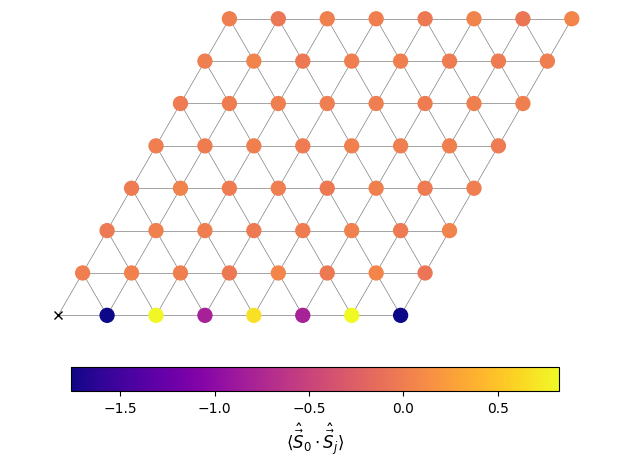

In [44]:
tri_open = nk.graph.Triangular(extent=[L, L], pbc=False)

xcoords = TriGraph.positions[:, 0]
ycoords = TriGraph.positions[:, 1]

plt.figure()
# plt.title(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$ for vit44_reflection on 8x8 lattice')
plt.xlabel('x-direction')
plt.ylabel('y-direction')
plt.axis('equal')
plt.axis('off')  # Remove the coordinate frame
for edge in tri_open.edges():
    start, end = tri_open._positions[edge[0]], tri_open._positions[edge[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=0.5, alpha=0.5, zorder=1)

plt.plot(xcoords[0], ycoords[0], marker='x', color='black')
sc = plt.scatter(x=xcoords[1:], y=ycoords[1:], c=np.real(SpinSpin_Corrs['vit44_ref']), cmap='plasma', s=100, label=' α=1')

cbar = plt.colorbar(sc, orientation='horizontal', pad=0.1, shrink=0.8)  # Adjust shrink to control size
cbar.set_label(r'$\langle \hat{\vec{S}}_0 \cdot\hat{\vec{S}}_j \rangle$', fontsize=12)
plt.tight_layout()
plt.savefig(fname='SpinSpin_Corrs_8x8_Lattice_vit44.png', dpi=300, bbox_inches='tight')
plt.show()

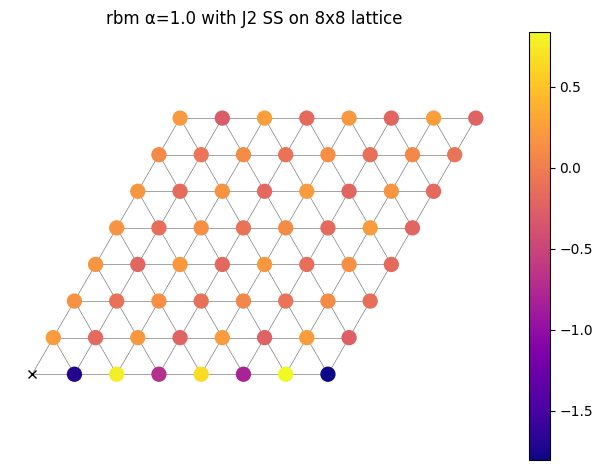

In [43]:
tri_open = nk.graph.Triangular(extent=[L, L], pbc=False)

xcoords = TriGraph.positions[:, 0]
ycoords = TriGraph.positions[:, 1]

plt.figure()
plt.title('rbm α=1.0 with J2 SS on 8x8 lattice')

plt.xlabel('x-direction')
plt.ylabel('y-direction')
plt.axis('equal')
plt.axis('off')  # Remove the coordinate frame
for edge in tri_open.edges():
    start, end = tri_open._positions[edge[0]], tri_open._positions[edge[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=0.5, alpha=0.5, zorder=1)

plt.plot(xcoords[0], ycoords[0], marker='x', color='black')
plt.scatter(x=xcoords[1:], y=ycoords[1:], c=np.real(SpinSpin_Corrs[' rbm_alpha1.0_SS']), cmap='plasma', s=100, label=' α=1')
plt.colorbar()
plt.tight_layout()

plt.show()


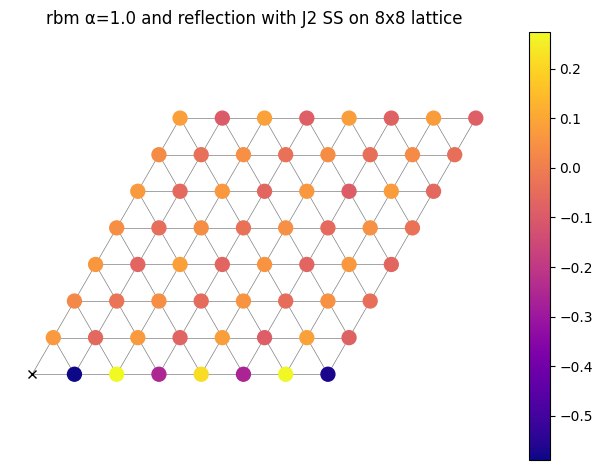

In [114]:
tri_open = nk.graph.Triangular(extent=[L, L], pbc=False)

xcoords = TriGraph.positions[:, 0]
ycoords = TriGraph.positions[:, 1]

plt.figure()
plt.title('rbm α=1.0 and reflection with J2 SS on 8x8 lattice')
plt.xlabel('x-direction')
plt.ylabel('y-direction')
plt.axis('equal')
plt.axis('off')  # Remove the coordinate frame
for edge in tri_open.edges():
    start, end = tri_open._positions[edge[0]], tri_open._positions[edge[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=0.5, alpha=0.5, zorder=1)

plt.plot(xcoords[0], ycoords[0], marker='x', color='black')
plt.scatter(x=xcoords[1:], y=ycoords[1:], c=np.real(SpinSpin_Corrs[' rbm_alpha1.0_full_SS']), cmap='plasma', s=100, label=' α=1')
plt.colorbar()
plt.tight_layout()

plt.show()


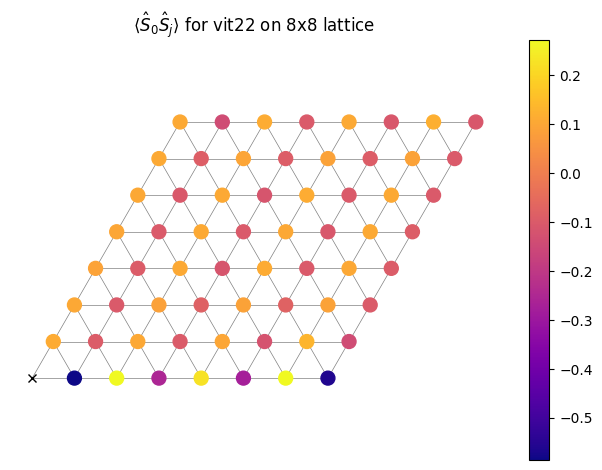

In [15]:
tri_open = nk.graph.Triangular(extent=[L, L], pbc=False)

xcoords = TriGraph.positions[:, 0]
ycoords = TriGraph.positions[:, 1]

plt.figure()
plt.title(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$ for vit22 on 8x8 lattice')
plt.xlabel('x-direction')
plt.ylabel('y-direction')
plt.axis('equal')
plt.axis('off')  # Remove the coordinate frame
for edge in tri_open.edges():
    start, end = tri_open._positions[edge[0]], tri_open._positions[edge[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=0.5, alpha=0.5, zorder=1)

plt.plot(xcoords[0], ycoords[0], marker='x', color='black')
plt.scatter(x=xcoords[1:], y=ycoords[1:], c=np.real(SpinSpin_Corrs['vit22']), cmap='plasma', s=100, label=' α=1')
plt.colorbar()
plt.tight_layout()

plt.show()

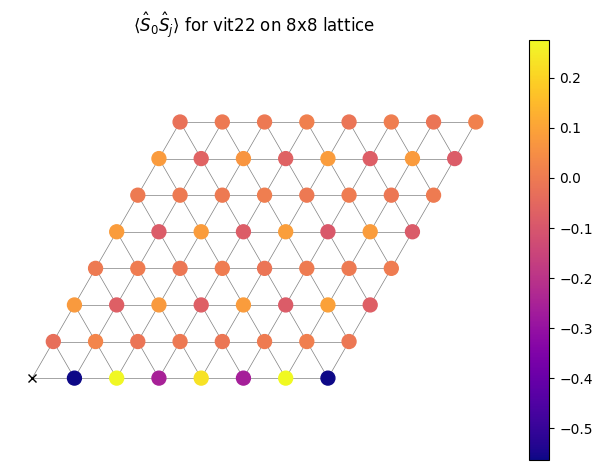

In [123]:
tri_open = nk.graph.Triangular(extent=[L, L], pbc=False)

xcoords = TriGraph.positions[:, 0]
ycoords = TriGraph.positions[:, 1]

plt.figure()
plt.title(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$ for vit22 on 8x8 lattice')
plt.xlabel('x-direction')
plt.ylabel('y-direction')
plt.axis('equal')
plt.axis('off')  # Remove the coordinate frame
for edge in tri_open.edges():
    start, end = tri_open._positions[edge[0]], tri_open._positions[edge[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=0.5, alpha=0.5, zorder=1)

plt.plot(xcoords[0], ycoords[0], marker='x', color='black')
plt.scatter(x=xcoords[1:], y=ycoords[1:], c=np.real(SpinSpin_Corrs['vit22_ref']), cmap='plasma', s=100, label=' α=1')
plt.colorbar()
plt.tight_layout()

plt.show()

## Compute Structure Factor

In [16]:
pi = np.pi
nodes = [
    (-4*pi/3, 0),  # Leftmost node
    (-2*pi/3, -2*pi/np.sqrt(3)),  # Bottom left
    (2*pi/3, -2*pi/np.sqrt(3)),  # Bottom right
    (4*pi/3, 0),  # Rightmost node
    (2*pi/3, 2*pi/np.sqrt(3)),  # Top right
    (-2*pi/3, 2*pi/np.sqrt(3)),  # Top left
    (-4*pi/3, 0)  # Close the hexagon by repeating the first node
]

x_coords, y_coords = zip(*nodes)
ks = FourierPoints_In_BrioullinZone(8, 100)

In [20]:
ds = Create_Differences(TriGraph)
sss, ss_err = Create_SpinSpin_Vec(vit_44,hi2d, TriGraph, get_error=True)
# FourierPoints_In_BrioullinZone
ks = FourierPoints_In_BrioullinZone(8, 100)
Sk_vit44, Sk_vit_err= vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, sss, hi2d.size, ss_err)

In [ ]:
# with open('StructureFactor_vit44.pickle', 'wb') as f:
#     pickle.dump((Sk_vit44, Sk_vit_err), f)
# with open('StructureFactor_vit44_errors.pickle', 'wb') as f:
#     pickle.dump((Sk_vit_err), f)

In [37]:
# position = np.where((np.isclose(ks[:, 0], 3.14)) & (np.isclose(ks[:, 1], 0.0)))
# position = position = np.where((np.isclose(ks[:, 0], 3.14)) )
np.where(np.all(np.isclose(ks , (3.14159, 0.0)), axis=1))
# print(position)

(array([189]),)

In [14]:
with open('StructureFactor_vit44.pickle', 'rb') as f:
    Sk_vit44, Sk_vit_err = pickle.load(f)
# with open('StructureFactor_vit44_errors.pickle', 'rb') as f:
#     Sk_vit_err=pickle.load(f)

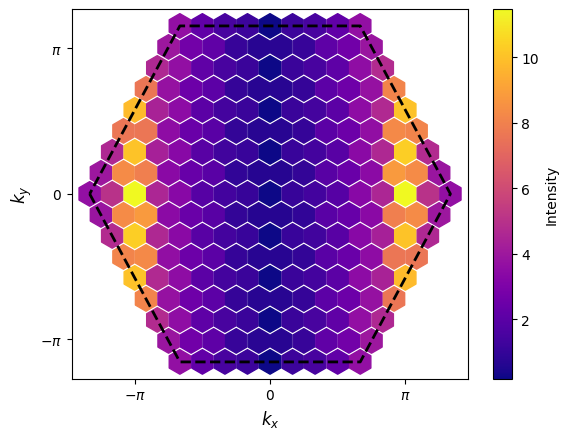

In [17]:
thickness = 20000 / L**2 
# plt.title(r'Structure factor for ViT_44 on 8x8 lattice')
# im1 = axes[0].scatter(ks[:, 0], ks[:, 1], c=Sk_rbm1.real, cmap='plasma', s=thickness, marker='h')
plt.plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
plt.scatter(ks[:,0], ks[:,1], c=np.real(Sk_vit44), s=thickness, cmap='plasma', marker='h')
# plt.imshow(Sk_vit22.reshape((dim, dim)).real.T, extent=[ks.min(), ks.max(), ks.min(), ks.max()], cmap='plasma')
# plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='o')
# Set ticks for x and y axes
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$', fontsize=12)
plt.ylabel(r'$k_y$', fontsize=12)
plt.colorbar(label='Intensity')
plt.savefig(fname='StructureFactor_8x8_vit44.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
ds = Create_Differences(TriGraph)
sss, ss_err = Create_SpinSpin_Vec(vit_44_ref,hi2d, TriGraph, get_error=True, sharding=True)
# FourierPoints_In_BrioullinZone
ks = FourierPoints_In_BrioullinZone(8, 100)
Sk_vit44_ref, Sk_vit44_ref_err= vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, sss, hi2d.size, ss_err)

In [18]:
# with open('StructureFactor_vit44_reflect.pickle', 'wb') as f:
#     pickle.dump((Sk_vit44_ref, Sk_vit44_ref_err), f)

with open('StructureFactor_vit44_reflect.pickle', 'rb') as f:
    Sk_vit44_ref, Sk_vit44_ref_err = pickle.load(f)

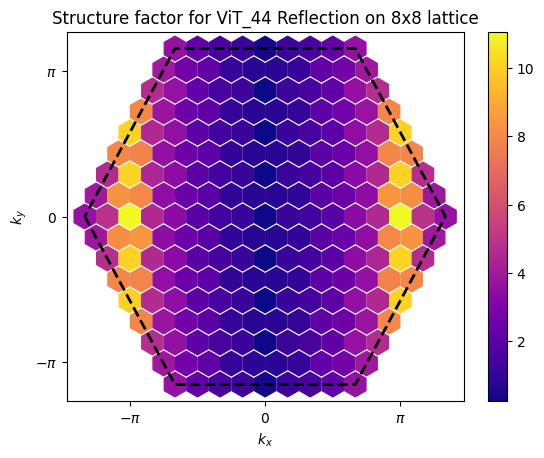

In [14]:
thickness = 20000 / L**2 
plt.title(r'Structure factor for ViT_44 Reflection on 8x8 lattice')
# im1 = axes[0].scatter(ks[:, 0], ks[:, 1], c=Sk_rbm1.real, cmap='plasma', s=thickness, marker='h')
plt.plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
plt.scatter(ks[:,0], ks[:,1], c=np.real(Sk_vit44_ref), s=thickness, cmap='plasma', marker='h')
# plt.imshow(Sk_vit22.reshape((dim, dim)).real.T, extent=[ks.min(), ks.max(), ks.min(), ks.max()], cmap='plasma')
# plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='o')
# Set ticks for x and y axes
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
plt.savefig(fname='StructureFactor_8x8_vit44.png', dpi=300, bbox_inches='tight')
plt.show()

In [104]:
ds = Create_Differences(TriGraph)
pHa['sublattice'] = [0,1,2,3,4,5,6,7,
                   16,17,18,19,20,21,22,23,
                   32,33,34,35,36,37,38,39,
                   48,49,50,51,52,53,54,55]
ss_44_SS, ss_err_SS_44 = Create_SpinSpin_Vec(vit_44_signJ2 ,hi2d, TriGraph, get_error=True, make_rotation=True, sublattice=pHa['sublattice'], sharding=True)
# FourierPoints_In_BrioullinZone
ks = FourierPoints_In_BrioullinZone(8, 100)
Sk_vit44_SSJ2, Sk_vit_err_SSJ2= vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, ss_44_SS, hi2d.size, ss_err_SS_44)


In [ ]:
# with open('StructureFactor_vit44_SSJ2.pickle', 'wb') as f:
#     pickle.dump((Sk_vit44_SSJ2, Sk_vit_err_SSJ2), f)


with open('StructureFactor_vit44_SSJ2.pickle', 'rb') as f:
    Sk_vit44_SSJ2, Sk_vit_err_SSJ2 = pickle.load(f)



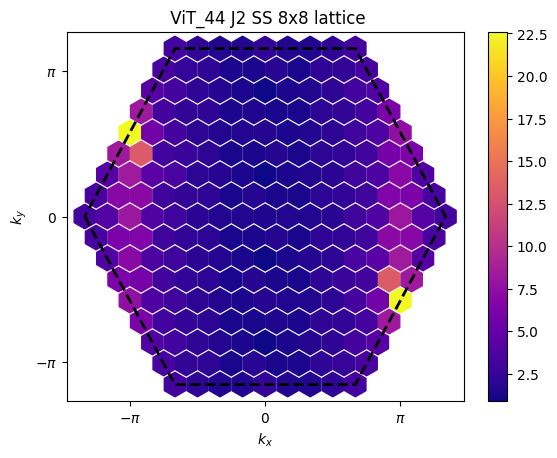

In [107]:
thickness = 20000 / L**2 
ks = FourierPoints_In_BrioullinZone(8, 100)

plt.title(r' ViT_44 J2 SS 8x8 lattice')
# im1 = axes[0].scatter(ks[:, 0], ks[:, 1], c=Sk_rbm1.real, cmap='plasma', s=thickness, marker='h')
plt.plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
plt.scatter(ks[:,0], ks[:,1], c=Sk_vit44_SSJ2.real, s=thickness, cmap='plasma', marker='h')
# plt.imshow(Sk_vit22.reshape((dim, dim)).real.T, extent=[ks.min(), ks.max(), ks.min(), ks.max()], cmap='plasma')
# plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='o')
# Set ticks for x and y axes
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
# plt.savefig(fname='StructureFactor_8x8.png', dpi=300, bbox_inches='tight')
plt.show()

In [137]:
ds = Create_Differences(TriGraph)
pHa['sublattice'] = [0,1,2,3,4,5,6,7,
                   16,17,18,19,20,21,22,23,
                   32,33,34,35,36,37,38,39,
                   48,49,50,51,52,53,54,55]
ss_44_SSJ2_ref, ss_err_SSJ2_ref_44 = Create_SpinSpin_Vec(vit_44_signJ2_ref ,hi2d, TriGraph, get_error=True, make_rotation=True, sublattice=pHa['sublattice'], sharding=True)
# FourierPoints_In_BrioullinZone
ks = FourierPoints_In_BrioullinZone(8, 100)
Sk_vit44_SSJ2_ref, Sk_vit_err_SSJ2_ref= vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, ss_44_SSJ2_ref, hi2d.size, ss_err_SSJ2_ref_44)


In [19]:
# with open('StructureFactor_vit44_SSJ2_ref.pickle', 'wb') as f:
#     pickle.dump((Sk_vit44_SSJ2_ref, Sk_vit_err_SSJ2_ref), f)


with open('StructureFactor_vit44_SSJ2_ref.pickle', 'rb') as f:
    Sk_vit44_SSJ2_ref, Sk_vit_err_SSJ2_ref = pickle.load(f)

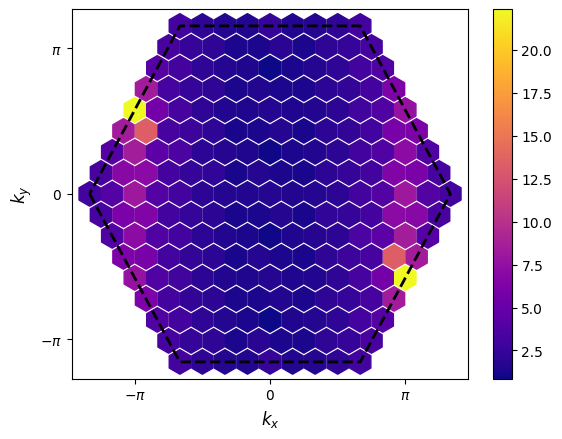

In [55]:
thickness = 20000 / L**2 
ks = FourierPoints_In_BrioullinZone(8, 100)

# plt.title(r' ViT_44 J2 SS reflection 8x8 lattice')
# im1 = axes[0].scatter(ks[:, 0], ks[:, 1], c=Sk_rbm1.real, cmap='plasma', s=thickness, marker='h')
plt.plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
plt.scatter(ks[:,0], ks[:,1], c=Sk_vit44_SSJ2_ref.real, s=thickness, cmap='plasma', marker='h')
# plt.imshow(Sk_vit22.reshape((dim, dim)).real.T, extent=[ks.min(), ks.max(), ks.min(), ks.max()], cmap='plasma')
# plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='o')
# Set ticks for x and y axes
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$', fontsize=12)
plt.ylabel(r'$k_y$', fontsize=12)
plt.colorbar()
plt.savefig(fname='StructureFactor_8x8_vit44_J2_sign.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
np.max(Sk_vit44_SS.real)

Array(20.96056738, dtype=float64)

In [108]:
ds = Create_Differences(TriGraph)
pHa['sublattice'] = sublattice(L)
ss_44_SSJ3, ss_err_SSJ3_44= Create_SpinSpin_Vec(vit_44_signJ3 ,hi2d, TriGraph, get_error=True, make_rotation=True, sublattice=pHa['sublattice'], sharding=True)
# FourierPoints_In_BrioullinZone
ks = FourierPoints_In_BrioullinZone(8, 100)
Sk_vit44_SSJ3, Sk_vit_err_SSJ3= vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, ss_44_SSJ3, hi2d.size, ss_err_SSJ3_44)


In [20]:
# with open('StructureFactor_vit44_SSJ3.pickle', 'wb') as f:
#     pickle.dump((Sk_vit44_SSJ3,Sk_vit_err_SSJ3), f)

with open('StructureFactor_vit44_SSJ3.pickle', 'rb') as f:
    Sk_vit44_SSJ3,Sk_vit_err_SSJ3 = pickle.load(f)

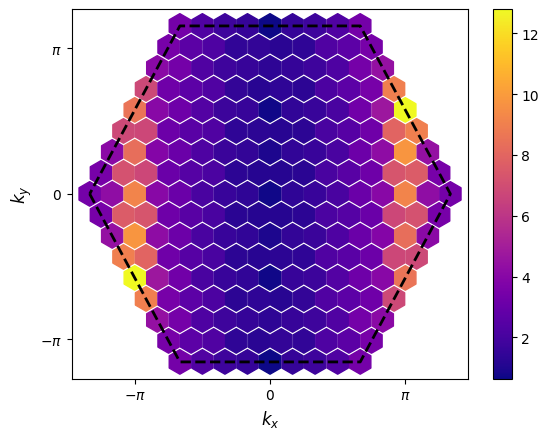

In [21]:
thickness = 20000 / L**2 
# plt.title(r' ViT_44 J3 SS 8x8 lattice')
plt.plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
plt.scatter(ks[:,0], ks[:,1], c=Sk_vit44_SSJ3.real, s=thickness, cmap='plasma', marker='h')
# plt.imshow(Sk_vit22.reshape((dim, dim)).real.T, extent=[ks.min(), ks.max(), ks.min(), ks.max()], cmap='plasma')
# plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='o')
# Set ticks for x and y axes
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$', fontsize=12)
plt.ylabel(r'$k_y$', fontsize=12)
plt.colorbar()
plt.savefig(fname='StructureFactor_8x8_vit44_J3_sign.png', dpi=300, bbox_inches='tight')
plt.show()

In [115]:
ds = Create_Differences(TriGraph)
pHa['sublattice'] = sublattice(L)
ss_44_SSJ3_ref, ss_err_SSJ3_44_ref= Create_SpinSpin_Vec(vit_44_signJ3_ref ,hi2d, TriGraph, get_error=True, make_rotation=True, sublattice=pHa['sublattice'], sharding=True)
# FourierPoints_In_BrioullinZone
ks = FourierPoints_In_BrioullinZone(8, 100)
Sk_vit44_SSJ3_ref, Sk_vit_err_SSJ3_ref= vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, ss_44_SSJ3_ref, hi2d.size, ss_err_SSJ3_44_ref)


In [125]:
# with open('StructureFactor_vit44_SSJ3_ref.pickle', 'wb') as f:
#     pickle.dump((Sk_vit44_SSJ3_ref,Sk_vit_err_SSJ3_ref), f)

with open('StructureFactor_vit44_SSJ3_ref.pickle', 'rb') as f:
    Sk_vit44_SSJ3_ref,Sk_vit_err_SSJ3_ref = pickle.load(f)

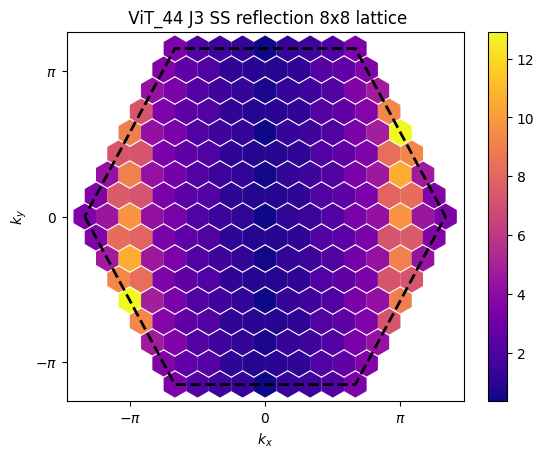

In [126]:
thickness = 20000 / L**2 
plt.title(r' ViT_44 J3 SS reflection 8x8 lattice')
plt.plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
plt.scatter(ks[:,0], ks[:,1], c=Sk_vit44_SSJ3_ref.real, s=thickness, cmap='plasma', marker='h')
# plt.imshow(Sk_vit22.reshape((dim, dim)).real.T, extent=[ks.min(), ks.max(), ks.min(), ks.max()], cmap='plasma')
# plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='o')
# Set ticks for x and y axes
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
# plt.savefig(fname='StructureFactor_8x8.png', dpi=300, bbox_inches='tight')
plt.show()

In [132]:
ds = Create_Differences(TriGraph)
pHa['sublattice'] = [0,2,4,6,9,11,13,15,16,18,20,22,25,27,29,31,
                   32,34,36,38,41,43,45,47,48,50,52,54,57,59,61,63]
ss_44_SSJ2_diff_ref, ss_err_SSJ2_diff_44_ref= Create_SpinSpin_Vec(vit_44_signJ2_Diff_ref ,hi2d, TriGraph, get_error=True, make_rotation=True, sublattice=pHa['sublattice'], sharding=True)
# FourierPoints_In_BrioullinZone
ks = FourierPoints_In_BrioullinZone(8, 100)
Sk_vit44_SSJ2_diff_ref, Sk_vit_err_SSJ2_diff_ref= vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, ss_44_SSJ2_diff_ref, hi2d.size, ss_err_SSJ2_diff_44_ref)


In [22]:
# with open('StructureFactor_vit44_SSJ2_diff_ref.pickle', 'wb') as f:
#     pickle.dump((Sk_vit44_SSJ2_diff_ref,Sk_vit_err_SSJ2_diff_ref), f)

with open('StructureFactor_vit44_SSJ2_diff_ref.pickle', 'rb') as f:
    Sk_vit44_SSJ2_diff_ref,Sk_vit_err_SSJ2_diff_ref = pickle.load(f)

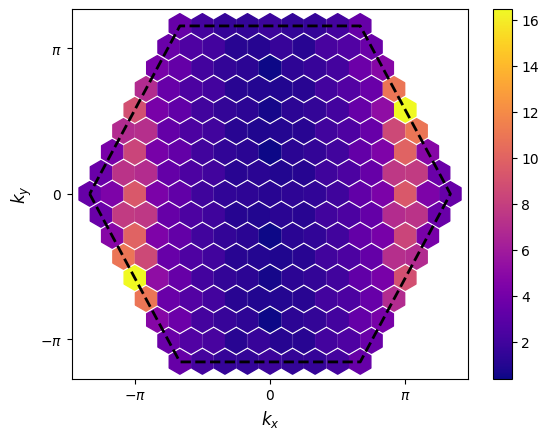

In [23]:
thickness = 20000 / L**2 
# plt.title(r' ViT_44 J2 SS diff reflection 8x8 lattice')
plt.plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
plt.scatter(ks[:,0], ks[:,1], c=Sk_vit44_SSJ2_diff_ref.real, s=thickness, cmap='plasma', marker='h')
# plt.imshow(Sk_vit22.reshape((dim, dim)).real.T, extent=[ks.min(), ks.max(), ks.min(), ks.max()], cmap='plasma')
# plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='o')
# Set ticks for x and y axes
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$', fontsize=12)
plt.ylabel(r'$k_y$', fontsize=12)
plt.colorbar()
plt.savefig(fname='StructureFactor_8x8_vit44_J2_sign_Diff.png', dpi=300, bbox_inches='tight')
plt.show()

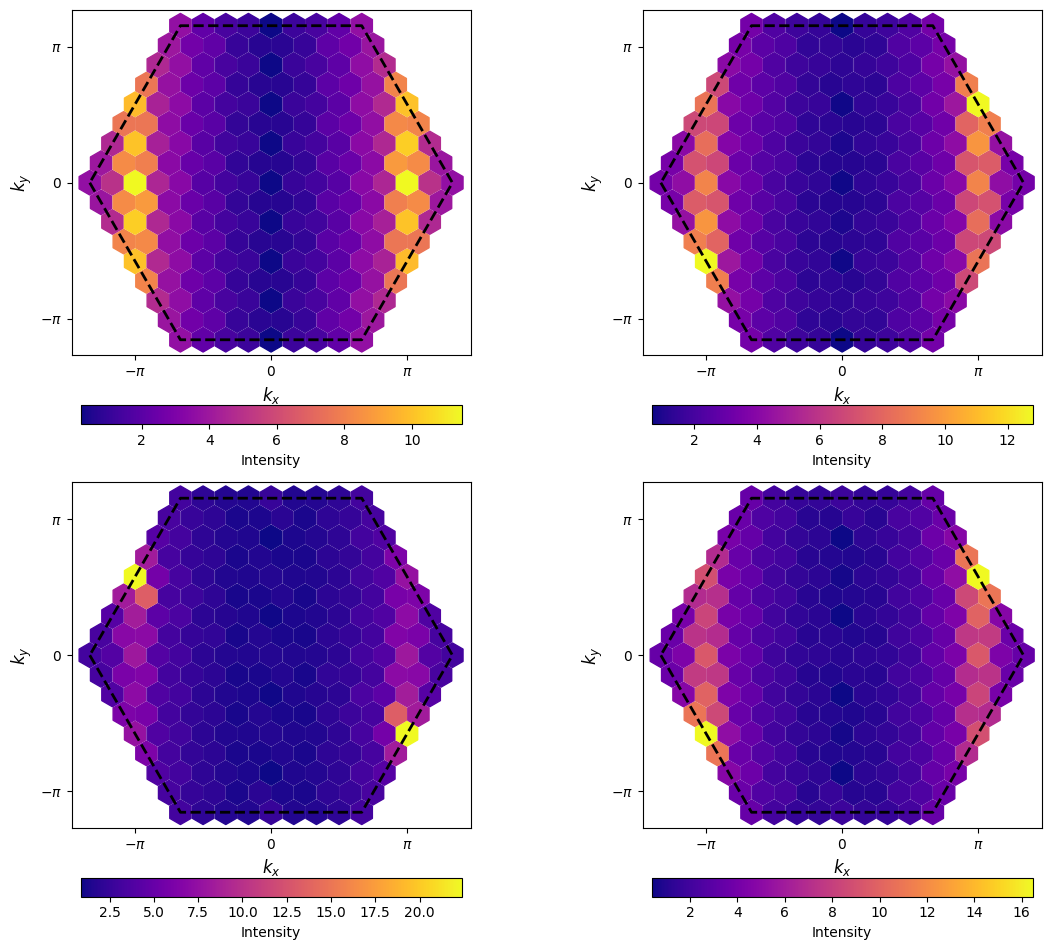

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot Sk_vit44
axes[0, 0].plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
scatter1 = axes[0, 0].scatter(ks[:, 0], ks[:, 1], c=Sk_vit44.real, s=thickness, cmap='plasma', marker='h')
axes[0, 0].set_xticks(ticks)
axes[0, 0].set_xticklabels(tick_labels)
axes[0, 0].set_yticks(ticks)
axes[0, 0].set_yticklabels(tick_labels)
axes[0, 0].set_xlabel(r'$k_x$', fontsize=12)
axes[0, 0].set_ylabel(r'$k_y$', fontsize=12)
axes[0, 0].set_aspect('equal')  # Ensure equal axis length
cbar1 = fig.colorbar(scatter1, ax=axes[0, 0], orientation='horizontal', fraction=0.046, pad=0.12)
cbar1.set_label('Intensity')

# Plot Sk_vit44_SSJ3
axes[0, 1].plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
scatter2 = axes[0, 1].scatter(ks[:, 0], ks[:, 1], c=Sk_vit44_SSJ3.real, s=thickness, cmap='plasma', marker='h')
axes[0, 1].set_xticks(ticks)
axes[0, 1].set_xticklabels(tick_labels)
axes[0, 1].set_yticks(ticks)
axes[0, 1].set_yticklabels(tick_labels)
axes[0, 1].set_xlabel(r'$k_x$', fontsize=12)
axes[0, 1].set_ylabel(r'$k_y$', fontsize=12)
axes[0, 1].set_aspect('equal')  # Ensure equal axis length
cbar2 = fig.colorbar(scatter2, ax=axes[0, 1], orientation='horizontal', fraction=0.046, pad=0.12)
cbar2.set_label('Intensity')

# Plot Sk_vit44_SSJ2_diff_ref
axes[1, 0].plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
scatter3 = axes[1, 0].scatter(ks[:, 0], ks[:, 1], c=Sk_vit44_SSJ2_ref.real, s=thickness, cmap='plasma', marker='h')
axes[1, 0].set_xticks(ticks)
axes[1, 0].set_xticklabels(tick_labels)
axes[1, 0].set_yticks(ticks)
axes[1, 0].set_yticklabels(tick_labels)
axes[1, 0].set_xlabel(r'$k_x$', fontsize=12)
axes[1, 0].set_ylabel(r'$k_y$', fontsize=12)
axes[1, 0].set_aspect('equal')  # Ensure equal axis length
cbar3 = fig.colorbar(scatter3, ax=axes[1, 0], orientation='horizontal', fraction=0.046, pad=0.12)
cbar3.set_label('Intensity')

# Plot Sk_vit44_SSJ2_ref
axes[1, 1].plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
scatter4 = axes[1, 1].scatter(ks[:, 0], ks[:, 1], c=Sk_vit44_SSJ2_diff_ref.real, s=thickness, cmap='plasma', marker='h')
axes[1, 1].set_xticks(ticks)
axes[1, 1].set_xticklabels(tick_labels)
axes[1, 1].set_yticks(ticks)
axes[1, 1].set_yticklabels(tick_labels)
axes[1, 1].set_xlabel(r'$k_x$', fontsize=12)
axes[1, 1].set_ylabel(r'$k_y$', fontsize=12)
axes[1, 1].set_aspect('equal')  # Ensure equal axis length
cbar4 = fig.colorbar(scatter4, ax=axes[1, 1], orientation='horizontal', fraction=0.046, pad=0.12)
cbar4.set_label('Intensity')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(fname='StructureFactor_8x8_vit44_all.png', dpi=300, bbox_inches='tight')
plt.show()

In [135]:
ds = Create_Differences(TriGraph)
pHa['sublattice'] = [0,2,4,6,9,11,13,15,16,18,20,22,25,27,29,31,
                   32,34,36,38,41,43,45,47,48,50,52,54,57,59,61,63]
ss_44_SSJ2_diff, ss_err_SSJ2_diff_44= Create_SpinSpin_Vec(vit_44_signJ2_Diff,hi2d, TriGraph, get_error=True, make_rotation=True, sublattice=pHa['sublattice'], sharding=True)
# FourierPoints_In_BrioullinZone
ks = FourierPoints_In_BrioullinZone(8, 100)
Sk_vit44_SSJ2_diff, Sk_vit_err_SSJ2_diff= vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, ss_44_SSJ2_diff, hi2d.size, ss_err_SSJ2_diff_44)


In [142]:
with open('StructureFactor_vit44_SSJ2_diff.pickle', 'wb') as f:
    pickle.dump((Sk_vit44_SSJ2_diff,Sk_vit_err_SSJ2_diff), f)

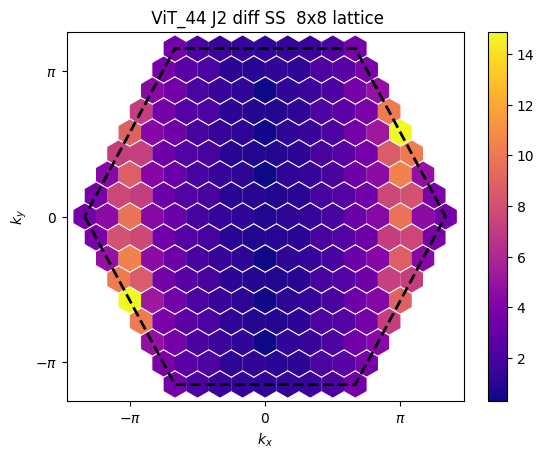

In [138]:
thickness = 20000 / L**2 
plt.title(r' ViT_44 J2 diff SS  8x8 lattice')
plt.plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
plt.scatter(ks[:,0], ks[:,1], c=Sk_vit44_SSJ2_diff.real, s=thickness, cmap='plasma', marker='h')
# plt.imshow(Sk_vit22.reshape((dim, dim)).real.T, extent=[ks.min(), ks.max(), ks.min(), ks.max()], cmap='plasma')
# plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='o')
# Set ticks for x and y axes
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
# plt.savefig(fname='StructureFactor_8x8.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
ds = Create_Differences(TriGraph)

ss_rbm1, ss_err_rbm1 = Create_SpinSpin_Vec(vs_rbm1_SS ,hi2d, TriGraph, get_error=True, make_rotation=True, sublattice=pHa['sublattice'])
# FourierPoints_In_BrioullinZone
ks = FourierPoints_In_BrioullinZone(8, 100)
Sk_rbm1, Sk_vit_rbm1= vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, ss_rbm1, hi2d.size, ss_err_rbm1)


In [30]:
with open('StructureFactor_rbm1_SS.pickle', 'wb') as f:
    pickle.dump((Sk_rbm1, Sk_vit_rbm1), f)
with open('StructureFactor_rbm1_SS_errors.ipckle', 'wb') as f:
    pickle.dump((Sk_vit_rbm1), f)

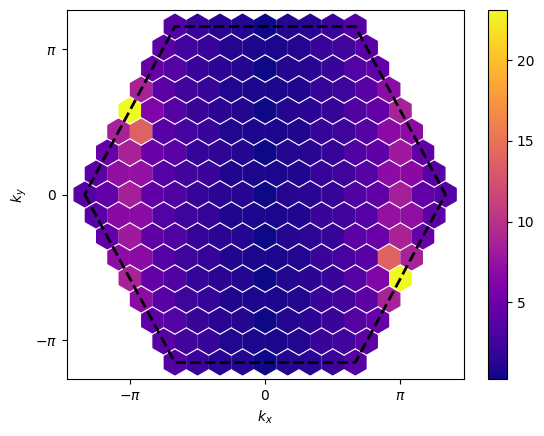

In [31]:
thickness = 20000 / L**2 
# im1 = axes[0].scatter(ks[:, 0], ks[:, 1], c=Sk_rbm1.real, cmap='plasma', s=thickness, marker='h')
plt.plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
plt.scatter(ks[:,0], ks[:,1], c=Sk_rbm1.real, s=thickness, cmap='plasma', marker='h')
# plt.imshow(Sk_vit22.reshape((dim, dim)).real.T, extent=[ks.min(), ks.max(), ks.min(), ks.max()], cmap='plasma')
# plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='o')
# Set ticks for x and y axes
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
# plt.savefig(fname='StructureFactor_8x8.png', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
ds = Create_Differences(TriGraph)
ss_22, ss_22_err = Create_SpinSpin_Vec(vit_22,hi2d, TriGraph, get_error=True)
# FourierPoints_In_BrioullinZone
ks = FourierPoints_In_BrioullinZone(8, 100)
Sk_vit22, Sk_vit22_err= vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, ss_22, hi2d.size, ss_22_err)

In [127]:
with open('StructureFactor_vit22.pickle', 'wb') as f:
    pickle.dump((Sk_vit22, Sk_vit22_err), f)
# with open('StructureFactor_vit22_errors.pickle', 'wb') as f:
#     pickle.dump((Sk_vit22_err), f)

In [128]:
with open('StructureFactor_vit22.pickle', 'rb') as f:
    Sk_vit22, Sk_vit22_err = pickle.load(f)

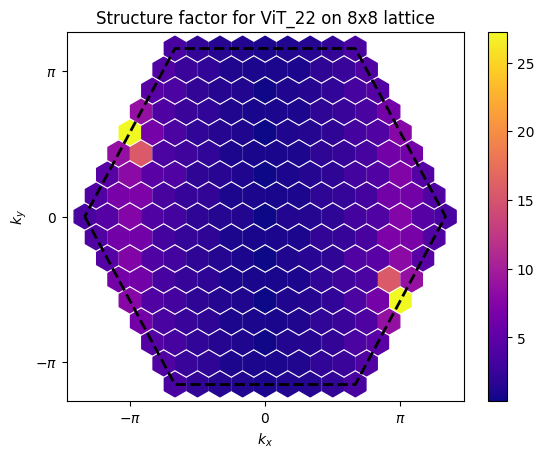

In [129]:
thickness = 20000 / L**2 
plt.title(r'Structure factor for ViT_22 on 8x8 lattice')
plt.plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
plt.scatter(ks[:,0], ks[:,1], c=Sk_vit22.real, s=thickness, cmap='plasma', marker='h')
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
# plt.savefig(fname='StructureFactor_8x8.png', dpi=300, bbox_inches='tight')
plt.show()

In [120]:
ds = Create_Differences(TriGraph)
ss_22_ref, ss_22_err_ref = Create_SpinSpin_Vec(vit_22_ref,hi2d, TriGraph, get_error=True, sharding=True)
# FourierPoints_In_BrioullinZone
ks = FourierPoints_In_BrioullinZone(8, 100)
Sk_vit22_ref, Sk_vit22_err_ref= vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, ss_22_ref, hi2d.size, ss_22_err_ref)

In [130]:
# with open('StructureFactor_vit22_ref.pickle', 'wb') as f:
#     pickle.dump((Sk_vit22_ref, Sk_vit22_err_ref), f)


with open('StructureFactor_vit22_ref.pickle', 'rb') as f:
    Sk_vit22_ref, Sk_vit22_err_ref = pickle.load(f)

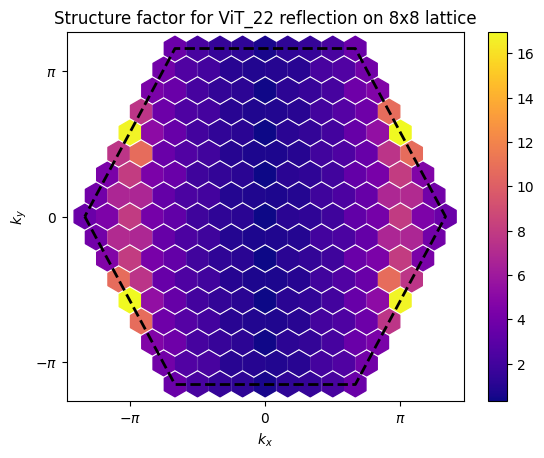

In [131]:
thickness = 20000 / L**2 
plt.title(r'Structure factor for ViT_22 reflection on 8x8 lattice')
plt.plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
plt.scatter(ks[:,0], ks[:,1], c=Sk_vit22_ref.real, s=thickness, cmap='plasma', marker='h')
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
# plt.savefig(fname='StructureFactor_8x8.png', dpi=300, bbox_inches='tight')
plt.show()